<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Image-features-exercise" data-toc-modified-id="Image-features-exercise-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image features exercise</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#hog-&amp;-hsv-features" data-toc-modified-id="hog-&amp;-hsv-features-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>hog &amp; hsv features</a></span></li><li><span><a href="#Extract-Features" data-toc-modified-id="Extract-Features-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Extract Features</a></span></li><li><span><a href="#Train-SVM-on-features" data-toc-modified-id="Train-SVM-on-features-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Train SVM on features</a></span><ul class="toc-item"><li><span><a href="#Inline-question-1:" data-toc-modified-id="Inline-question-1:-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Inline question 1:</a></span></li></ul></li><li><span><a href="#Neural-Network-on-image-features" data-toc-modified-id="Neural-Network-on-image-features-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Neural Network on image features</a></span></li></ul></li></ul></div>

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers **not on raw pixels but on features** that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## hog & hsv features
`cs231n.features`

In [3]:
def rgb2gray(rgb):
    """Convert RGB image to grayscale

      Parameters:
        rgb : RGB image

      Returns:
        gray : grayscale image

    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [4]:
def hog_feature(im):
    """Compute Histogram of Gradient (HOG) feature for an image

         Modified from skimage.feature.hog
         http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog

       Reference:
         Histograms of Oriented Gradients for Human Detection
         Navneet Dalal and Bill Triggs, CVPR 2005

      Parameters:
        im : an input grayscale or rgb image

      Returns:
        feat: Histogram of Gradient (HOG) feature

    """

    # convert rgb to grayscale if needed
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)

    sx, sy = image.shape # image size
    orientations = 9 # number of gradient bins
    cx, cy = (8, 8) # pixels per cell

    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :-1] = np.diff(image, n=1, axis=1) # compute gradient on x-direction
    gy[:-1, :] = np.diff(image, n=1, axis=0) # compute gradient on y-direction
    grad_mag = np.sqrt(gx ** 2 + gy ** 2) # gradient magnitude
    grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90 # gradient orientation

    n_cellsx = int(np.floor(sx / cx))  # number of cells in x
    n_cellsy = int(np.floor(sy / cy))  # number of cells in y
    # compute orientations integral images
    orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
    for i in range(orientations):
        # create new integral image for this orientation
        # isolate orientations in this range
        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                            grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                            temp_ori, 0)
        # select magnitudes for those orientations
        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[round(cx/2)::cx, round(cy/2)::cy].T

    return orientation_histogram.ravel()

In [5]:
def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):
    """
    Compute color histogram for an image using hue.

    Inputs:
    - im: H x W x C array of pixel data for an RGB image.
    - nbin: Number of histogram bins. (default: 10)
    - xmin: Minimum pixel value (default: 0)
    - xmax: Maximum pixel value (default: 255)
    - normalized: Whether to normalize the histogram (default: True)

    Returns:
      1D vector of length nbin giving the color histogram over the hue of the
      input image.
    """
    ndim = im.ndim
    bins = np.linspace(xmin, xmax, nbin+1)
    hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
    imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins, density=normalized)
    imhist = imhist * np.diff(bin_edges)

    # return histogram
    return imhist

In [6]:
from scipy.ndimage import uniform_filter

def extract_features(imgs, feature_fns, verbose=False):
    """
    Given pixel data for images and several feature functions that can operate on
    single images, apply all feature functions to all images, concatenating the
    feature vectors for each image and storing the features for all images in
    a single matrix.

    Inputs:
    - imgs: N x H X W X C array of pixel data for N images.
    - feature_fns: List of k feature functions. The ith feature function should
      take as input an H x W x D array and return a (one-dimensional) array of
      length F_i.
    - verbose: Boolean; if true, print progress.

    Returns:
    An array of shape (N, F_1 + ... + F_k) where each column is the concatenation
    of all features for a single image.
    """
    num_images = imgs.shape[0]
    if num_images == 0:
        return np.array([])

    # Use the first image to determine feature dimensions
    feature_dims = []
    first_image_features = []
    for feature_fn in feature_fns:
        feats = feature_fn(imgs[0].squeeze())
        assert len(feats.shape) == 1, 'Feature functions must be one-dimensional'
        feature_dims.append(feats.size)
        first_image_features.append(feats)

    # Now that we know the dimensions of the features, we can allocate a single
    # big array to store all features as columns.
    total_feature_dim = sum(feature_dims)
    imgs_features = np.zeros((num_images, total_feature_dim))
    imgs_features[0] = np.hstack(first_image_features).T

    # Extract features for the rest of the images.
    for i in range(1, num_images):
        idx = 0
        for feature_fn, feature_dim in zip(feature_fns, feature_dims):
            next_idx = idx + feature_dim
            imgs_features[i, idx:next_idx] = feature_fn(imgs[i].squeeze())
            idx = next_idx
        if verbose and i % 1000 == 999:
            print('Done extracting features for %d / %d images' % (i+1, num_images))

    return imgs_features

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [7]:
# from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength
from cs231n.classifiers.linear_classifier import LinearSVM

# learning_rates = [1e-9, 1e-8, 1e-7]
# regularization_strengths = [5e4, 5e5, 5e6]
learning_rates =[5e-9, 7.5e-9, 1e-8]
regularization_strengths = [(5+i)*1e6 for i in range(-3,4)]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for rs in regularization_strengths:
    for lr in learning_rates:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, lr, rs, num_iters=6000)
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm           
        results[(lr,rs)] = train_accuracy, val_accuracy
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-09 reg 2.000000e+06 train accuracy: 0.411571 val accuracy: 0.410000
lr 5.000000e-09 reg 3.000000e+06 train accuracy: 0.410980 val accuracy: 0.417000
lr 5.000000e-09 reg 4.000000e+06 train accuracy: 0.414531 val accuracy: 0.417000
lr 5.000000e-09 reg 5.000000e+06 train accuracy: 0.413000 val accuracy: 0.421000
lr 5.000000e-09 reg 6.000000e+06 train accuracy: 0.407571 val accuracy: 0.402000
lr 5.000000e-09 reg 7.000000e+06 train accuracy: 0.414469 val accuracy: 0.407000
lr 5.000000e-09 reg 8.000000e+06 train accuracy: 0.411612 val accuracy: 0.415000
lr 7.500000e-09 reg 2.000000e+06 train accuracy: 0.410878 val accuracy: 0.411000
lr 7.500000e-09 reg 3.000000e+06 train accuracy: 0.418816 val accuracy: 0.411000
lr 7.500000e-09 reg 4.000000e+06 train accuracy: 0.409816 val accuracy: 0.398000
lr 7.500000e-09 reg 5.000000e+06 train accuracy: 0.413388 val accuracy: 0.411000
lr 7.500000e-09 reg 6.000000e+06 train accuracy: 0.414163 val accuracy: 0.417000
lr 7.500000e-09 reg 7.000000

In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.419


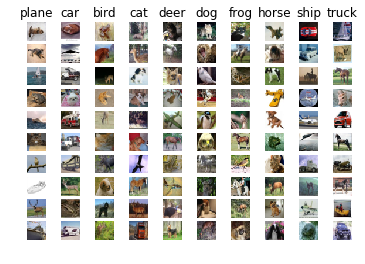

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [12]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

results = {}
best_val = -1
best_net = None

learning_rates = [1e-2 ,1e-1, 5e-1, 1, 5]
regularization_strengths = [1e-3, 5e-3, 1e-2, 1e-1, 0.5, 1]

for lr in learning_rates:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
        num_iters=1500, batch_size=200,
        learning_rate=lr, learning_rate_decay=0.95,
        reg= reg, verbose=False)
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        if val_acc > best_val:
            best_val = val_acc
            best_net = net         
        results[(lr,reg)] = val_acc

# Print out results.
for lr, reg in sorted(results):
    val_acc = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (
                lr, reg,  val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

/disk1/chenting/workspace/jupyter_workspace/cs231n/assignment1/cs231n/classifiers/neural_net.py:99: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(softmax_output[range(N), list(y)]))
/disk1/chenting/workspace/jupyter_workspace/cs231n/assignment1/cs231n/classifiers/neural_net.py:97: RuntimeWarning: overflow encountered in subtract
  shift_scores = scores - np.max(scores, axis = 1).reshape(-1,1)
/disk1/chenting/workspace/jupyter_workspace/cs231n/assignment1/cs231n/classifiers/neural_net.py:101: RuntimeWarning: overflow encountered in double_scalars
  loss +=  0.5* reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
/disk1/chenting/workspace/jupyter_workspace/cs231n/assignment1/cs231n/classifiers/neural_net.py:97: RuntimeWarning: invalid value encountered in subtract
  shift_scores = scores - np.max(scores, axis = 1).reshape(-1,1)
/disk1/chenting/workspace/jupyter_workspace/cs231n/assignment1/cs231n/classifiers/neural_net.py:101: RuntimeWarning: overflow encountered in mu

lr 1.000000e-02 reg 1.000000e-03 val accuracy: 0.175000
lr 1.000000e-02 reg 5.000000e-03 val accuracy: 0.200000
lr 1.000000e-02 reg 1.000000e-02 val accuracy: 0.168000
lr 1.000000e-02 reg 1.000000e-01 val accuracy: 0.079000
lr 1.000000e-02 reg 5.000000e-01 val accuracy: 0.113000
lr 1.000000e-02 reg 1.000000e+00 val accuracy: 0.079000
lr 1.000000e-01 reg 1.000000e-03 val accuracy: 0.518000
lr 1.000000e-01 reg 5.000000e-03 val accuracy: 0.523000
lr 1.000000e-01 reg 1.000000e-02 val accuracy: 0.514000
lr 1.000000e-01 reg 1.000000e-01 val accuracy: 0.424000
lr 1.000000e-01 reg 5.000000e-01 val accuracy: 0.098000
lr 1.000000e-01 reg 1.000000e+00 val accuracy: 0.112000
lr 5.000000e-01 reg 1.000000e-03 val accuracy: 0.579000
lr 5.000000e-01 reg 5.000000e-03 val accuracy: 0.572000
lr 5.000000e-01 reg 1.000000e-02 val accuracy: 0.540000
lr 5.000000e-01 reg 1.000000e-01 val accuracy: 0.399000
lr 5.000000e-01 reg 5.000000e-01 val accuracy: 0.079000
lr 5.000000e-01 reg 1.000000e+00 val accuracy: 0

In [13]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.552
